# Agent

# 準備

In [89]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv

# 環境変数の読み込み
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.environ["API_KEY"]

# Google検索Agent

In [90]:
from langchain.agents import Tool
from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()

tools = [
    Tool(
        name = "現在の検索",
        func=search.run,
        description="現在の出来事や世界の現状に関する質問に答える必要がある場合に役立ちます"
    )
]

In [91]:
from langchain import OpenAI
from langchain.agents import initialize_agent
from langchain.agents import AgentType

llm=OpenAI(
    temperature=0.8,
    max_tokens=1000)

agent_chain = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,)

In [4]:
agent_chain.run(input="広島サミットの結果について教えてください")



> Entering new  chain...
 公式な情報を集める必要がある
Action: 現在の検索
Action Input: "広島サミットの結果"
Observation: May 26, 2023 ... 5月19日から21日にかけて岸田総理大臣は広島にてG7サミットを議長として ... の下で速やかに議論させ、本年中に結果を報告させることで一致しました。 May 21, 2023 ... ... 会見し、「広島がG7サミットの会場に選ばれたことは、ICANとしては歓待したいと思っていた。しかし、結果については大変失望している」と述べた。 Apr 27, 2023 ... G7広島サミット準備会議（第三回会合）（結果） ... 会合においては、サミット期間中のG7首脳による平和記念公園及び宮島の訪問実現に向けて調整して ... May 24, 2023 ... 5月19日から21日にかけて、広島でG7サミットが開催。サミットではウクライナ情勢、対中関係、核軍縮、国際経済問題、制裁など多くの議題が取り上げ ... May 22, 2023 ... 被爆地・広島で開かれたG7サミット。ウクライナ情勢や核軍縮が大きなテーマとなり、... #nhk_kaisetsu. May 31, 2023 ... エマニュエル・マクロン大統領はG7サミットに出席するため、広島を訪問しました。 1 審査結果. 令和5年1月17日付けで公告した「G7広島サミット記念品製作等業務」公募型プロポーザルについて，次のとおり事業者候補者を決定しました。 May 21, 2023 ... 【岸田総理冒頭発言】. 先ほど、G7広島サミットは、全てのセッションを終了し閉幕いたしました。G7首脳、8つの招待国の首脳と7つの国際機関の ... 【日経】G7サミット（主要7カ国首脳会議）が2023年5月19～21日に広島市で開催。 ... 歴史的な転換期の中、我々は原子爆弾投下の結果、広島や長崎の人々が経験した ... Jun 7, 2023 ... IGESの視点：G7広島サミットの結果について ... 本ウェビナーでは、IGES研究員がG7広島首脳コミュニケを気候変動とエネルギー、生物多様性、資源効率 ...
Thought: 公式な情報を集めたので、結果をまとめることができる
Fin

'G7広島サミットでは、ウクライナ情勢、対中関係、核軍縮、国際経済問題、制裁など多くの議題が取り上げられ、各首脳が調整して本年中に結果を報告した。また、歴史的な転換期において、G7首脳は原子爆弾投下の結果を受け、広島や長崎の人々が経験した被害を記念するため、平和記念公園や宮島などを訪問することも確認した。'

In [94]:
# Agentが使用しているプロンプトを確認
print(agent_chain.agent.llm_chain.prompt.template)

Answer the following questions as best you can. You have access to the following tools:

現在の検索: 現在の出来事や世界の現状に関する質問に答える必要がある場合に役立ちます

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [現在の検索]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


# 対話型Google検索Agent

In [10]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="chat_history")

In [12]:
llm=OpenAI(
    temperature=0.8,
    max_tokens=1000)

agent_chain = initialize_agent(
    tools,
    llm,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    memory=memory)

In [13]:
agent_chain.run(input="こんにちは！")

'こんにちは！私はアシスタントです！どうすればお役に立てますか？'

In [16]:
agent_chain.run(input="8月の東京駅のイベントを教えてください")

'8月の東京駅で開催されているイベントは、「まじかるちいかわ」東京駅いちばんプラザで開催されている新感覚のイベントがあります。また、Q-pot CAFEの10周年を祝う期間限定イベントも開催されます。「丸ノ内ホテル アーバンビアテラス2023」や「日本ハム・東洋カープ 甲子園スタジアムで行われる催しもあります。さらに、サンシャイン水族館では「毒毒毒毒毒毒毒毒展（もうどく展）ReMix」が開催されます。また、テラス席でお楽しみいただける東京ソラマチ夏まつりや、東京都内で開催される「ご当地ラーメンチャレンジ by 東京ラーメンストリート」などのイベントもあります。'

In [17]:
agent_chain.run(input="面白そうですね！。「毒毒毒毒毒毒毒毒展（もうどく展）ReMix」はどこで実施しますか？")

'「毒毒毒毒毒毒毒毒展（もうどく展）ReMix」は、東京都江東区サンシャイン水族館で開催されています。'

In [18]:
agent_chain.run(input="ありがとうございました！")

'どういたしまして！何か今後のお役に立てることがありましたら、お気軽にご連絡ください。'

# Self ask with search

In [75]:
from langchain.utilities import GoogleSearchAPIWrapper
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

llm = OpenAI(temperature=0)

search = GoogleSearchAPIWrapper()

tools = [
    Tool(
        # agent=AgentType.SELF_ASK_WITH_SEARCHの場合、name="Intermediate Answer"である必要がある
        name="Intermediate Answer",
        func=search.run,
        description="検索で質問したい時に便利です",
    )
]

self_ask_with_search = initialize_agent(
    tools, llm, agent=AgentType.SELF_ASK_WITH_SEARCH, verbose=True
)
self_ask_with_search.run(
    "次の月食はいつ？"
)



> Entering new  chain...
 Yes.
Follow up: 何が月食ですか？
Intermediate answer: 月食の起こるしくみ. 地球と月は太陽の光を反射して輝く天体です。地球にも太陽の光による影があり、太陽と ... 姫路科学館・月食を見よう. 皆既月食の時の赤い月です. 月食は天文界の一大イベントで、テレビや新聞などでも取り上げられることが多いですが、何か特別な現象だから ... Nov 8, 2022 ... 皆既食は86分間続いて20時42分に終わり、その後は徐々に月は地球の影から抜けて、21時49分に部分食が終わります。この進行は、どこで見ても同じです。 Nov 7, 2022 ... 月食が人間に与える影響は何ですか？ 月食とは. 月食は、地球が太陽の光が月に到達するのを完全にまたは部分的 ... これは「日食（にっしょく）」という非常にめずらしい現象なのです。 日食には太陽全体が見えなくなる「皆既日食（かいきにっしょく）」、太陽が輪っかのように見える ... Nov 7, 2022 ... 明日11月8日(火)夜、日本全国で「皆既月食」が起こります。皆既月食は、月が地球の影に完全に隠されて、幻想的な赤銅色の満月が見られる天体現象です ... 「上弦の月の月食」とか「三日月の月食」というのは絶対におきない。 さて、地球の影には大きく2つの種類がある。 一つは「本影」と呼ばれる影で、太陽からの ... May 21, 2021 ... 日食や月食は記憶に残る天文現象です。お天気のこともあるので一生のうちに何回見られるかわかりませんが、食が起こる空の高さや食の継続 ... Nov 8, 2022 ... 今日11月8日(火)夜は、日本全国で「皆既月食」が起こりました。皆既月食は、月が地球の影に完全に隠されて、幻想的な赤銅色の満月が見られる天体現象です ... Nov 8, 2022 ... 【NHK】「皆既月食」が8日の夜、天気がよければ全国各地で見られます。今回「天王星食」も同時に見られ、このような現象が日本で見られ…
So the final answer is: November 8, 2022

> Finished chain.


'November 8, 2022'

In [95]:
# Agentが使用しているプロンプトを確認
print(self_ask_with_search.agent.llm_chain.prompt.template)

Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washin

# Index検索Agent

In [2]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

# PDFの読込
loader = PyPDFLoader("./data2/001615363.pdf")
documents = loader.load()

# チャンクに分割
text_splitter = CharacterTextSplitter(separator="\n", chunk_size=512, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

# Indexの構築
db = Chroma.from_documents(texts, OpenAIEmbeddings())

# RetrievalQAチェーンの作成
qa = RetrievalQA.from_chain_type(
    llm=OpenAI(temperature=1.2), chain_type="stuff", retriever=db.as_retriever()
)

In [3]:
from langchain.agents import Tool
from langchain.agents import AgentType

tools = [
    Tool(
        name="訪日外国人旅行者QAシステム",
        func=qa.run,
        description="訪日外国人の旅行や土産品、消費動向に関する質問に役立ちます。",
    ),
]

In [4]:
from langchain.agents import initialize_agent
from langchain import OpenAI

llm=OpenAI(
    temperature=0,
    max_tokens=1000)

agent_chain = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,)

In [5]:
agent_chain.run(input="お土産の購入状況を教えて")



> Entering new  chain...
 訪日外国人旅行者QAシステムを使って情報を収集する
Action: 訪日外国人旅行者QAシステム
Action Input: お土産の購入状況
Observation:  図表3-1で宝石・貴金属が最も購入率が高いことが分かります (70.4%) が、最も購入者単価が高い費目は台湾(19.9 万円)と香港 (16.6 万円)です。一方で図表3-2ではレジャー目的訪問以外では菓子類が最も購入率が高く (73.7%)、米国ではその他食料品・飲料・たばこが最も購入率が高く (65.1%) あります。
Thought: お土産の購入状況が分かった
Final Answer: 宝石・貴金属が最も購入率が高いことが分かりますが、最も購入者単価が高い費目は台湾(19.9 万円)と香港 (16.6 万円)です。レジャー目的訪問以外では菓子類が最も購入率が高く、米国ではその他食料品・飲料・たばこが最も購入率が高いことが分かります。

> Finished chain.


'宝石・貴金属が最も購入率が高いことが分かりますが、最も購入者単価が高い費目は台湾(19.9 万円)と香港 (16.6 万円)です。レジャー目的訪問以外では菓子類が最も購入率が高く、米国ではその他食料品・飲料・たばこが最も購入率が高いことが分かります。'

# OpenAI Function Call

In [21]:
import requests
from bs4 import BeautifulSoup
from langchain.chains import TransformChain

# ニュースを検索する関数
def get_news(inputs: dict) -> dict:
    keyword = inputs["keyword"]

    # WebサイトのURLを指定
    url = f'https://news.google.com/search?q={keyword}&hl=ja&gl=JP&ceid=JP:ja'

    # Requestsを利用してWebページを取得する
    response = requests.get(url)
    html = response.text

    # BeautifulSoupを利用してWebページを解析する
    soup = BeautifulSoup(html, 'html.parser')

    # soup.selectを利用して、ニュースのタイトルを取得する
    elements = soup.select('article h3 a')

    # ニュースのトップ3を配列に取得
    news = []
    for i, element in enumerate(elements):
        news.append({"title": element.getText()})
        if i>=2:
            break

    return {"result": news}

# 関数をChain化
news_chain = TransformChain(
    input_variables=["keyword"],
    output_variables=["result"],
    transform=get_news
)


In [22]:
# 数式の文字列をもとに計算を行う関数
def calc_func(inputs: dict) -> dict:
    formula = inputs["formula"]
    answer = eval(formula)
    return {"answer": f"{answer}"}

# 関数をChain化
calc_chain = TransformChain(
    input_variables=["formula"],
    output_variables=["answer"],
    transform=calc_func
)

In [23]:
from langchain.agents import Tool
from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()

tools = [
    Tool(
        name = "news", # 半角英数字のみ
        func=news_chain.run,
        description="ニュースを探す際に役立ちます"
    ),
    Tool(
        name = "calculation", # 半角英数字のみ
        func=calc_chain.run,
        description="計算をする場合に役立ちます"
    ),
    Tool(
        name = "Search", # 半角英数字のみ
        func=search.run,
        description="現在の出来事や世界の現状に関する質問に答える必要がある場合に役立ちます"
    ),
]

In [24]:
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI

llm=ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0)

agent_chain = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True,)

In [25]:
agent_chain.run(input="8掛ける12は？")



> Entering new  chain...

Invoking: `calculation` with `8 * 12`


968掛ける12は96です。

> Finished chain.


'8掛ける12は96です。'

In [26]:
agent_chain.run(input="夏祭りに関するニュースを教えてください")



> Entering new  chain...

Invoking: `news` with `{'keyword': '夏祭り'}`


[{'title': '「UDX 夏祭り」が4年ぶりに帰ってくる！7月28日から開催お笑い芸人のライブやVRお化け屋敷など、屋台や縁日もあり'}, {'title': 'どこか懐かしくて新しい夏祭りを天神の真ん中で。「天神夏まつり2023 」開催！'}, {'title': '大規模イベントから夏の恒例行事までそろい踏み！ 今週末のおすすめイベントをピックアップ'}]夏祭りに関するニュースですね。以下のニュースがあります。

1. 「UDX 夏祭り」が4年ぶりに帰ってくる！7月28日から開催お笑い芸人のライブやVRお化け屋敷など、屋台や縁日もあり
2. どこか懐かしくて新しい夏祭りを天神の真ん中で。「天神夏まつり2023 」開催！
3. 大規模イベントから夏の恒例行事までそろい踏み！ 今週末のおすすめイベントをピックアップ

詳細な情報は各ニュースをご覧ください。

> Finished chain.


'夏祭りに関するニュースですね。以下のニュースがあります。\n\n1. 「UDX 夏祭り」が4年ぶりに帰ってくる！7月28日から開催お笑い芸人のライブやVRお化け屋敷など、屋台や縁日もあり\n2. どこか懐かしくて新しい夏祭りを天神の真ん中で。「天神夏まつり2023 」開催！\n3. 大規模イベントから夏の恒例行事までそろい踏み！ 今週末のおすすめイベントをピックアップ\n\n詳細な情報は各ニュースをご覧ください。'

# Toolkit:Pandas DataFrame Agent

In [48]:
import pandas as pd

df = pd.read_csv("./data2/iris.data", header=0)

In [49]:
from langchain.agents import create_pandas_dataframe_agent

agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)

In [50]:
agent.run("何行ありますか？")



> Entering new  chain...
Thought: 答えを見つけるために、データフレームの行数を取得する必要があります。
Action: python_repl_ast
Action Input: len(df)
Observation: 150
Thought: 私は今答えを知っています
Final Answer: データフレームには150行があります。

> Finished chain.


'データフレームには150行があります。'

In [51]:
agent.run("Nameごとの基本統計量を表として出力してください")



> Entering new  chain...
Thought: Nameごとにデータを分けて、基本統計量を計算する
Action: python_repl_ast
Action Input: df.groupby('Name').describe()
Observation:                 SepalLength                                              \
                      count   mean       std  min    25%  50%  75%  max   
Name                                                                      
Iris-setosa            50.0  5.006  0.352490  4.3  4.800  5.0  5.2  5.8   
Iris-versicolor        50.0  5.936  0.516171  4.9  5.600  5.9  6.3  7.0   
Iris-virginica         50.0  6.588  0.635880  4.9  6.225  6.5  6.9  7.9   

                SepalWidth         ... PetalLength      PetalWidth         \
                     count   mean  ...         75%  max      count   mean   
Name                               ...                                      
Iris-setosa           50.0  3.418  ...       1.575  1.9       50.0  0.244   
Iris-versicolor       50.0  2.770  ...       4.600  5.1       50.0  1.326   
Iris-virginica       

'Name               Iris-setosa  Iris-versicolor  Iris-virginica\nSepalLength count    50.000000        50.000000       50.000000\n            mean      5.006000         5.936000        6.588000\n            std       0.352490         0.516171        0.635880\n            min       4.300000         4.900000        4.900000\n            25%       4.800000         5.600000        6.225000\n            50%       5.000000         5.900000        6.500000\n            75%       5.200000         6.300000        6.900000\n            max       5.800000         7.000000        7.900000\nSepalWidth  count    50.000000        50.000000       50.000000\n            mean      3.418000         2.770000        2.974000\n            std'

In [52]:
agent.run("このデータについて説明してください")



> Entering new  chain...
Thought: このデータフレームには何が含まれているかを確認する必要があります
Action: python_repl_ast
Action Input: df.columns
Observation: Index(['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Name'], dtype='object')
Thought: このデータフレームには、SepalLength、SepalWidth、PetalLength、PetalWidth、Nameの5つの列が含まれていることがわかりました
Final Answer: このデータフレームには、SepalLength、SepalWidth、PetalLength、PetalWidth、Nameの5つの列が含まれています。

> Finished chain.


'このデータフレームには、SepalLength、SepalWidth、PetalLength、PetalWidth、Nameの5つの列が含まれています。'



> Entering new  chain...
Thought: SepalLengthとSepalWidthを取り出して、Nameごとに色分けした散布図を作成する
Action: python_repl_ast
Action Input: df.plot.scatter(x='SepalLength', y='SepalWidth', c='Name', colormap='viridis')
Observation: Axes(0.125,0.11;0.62x0.77)
Thought: 散布図が作成された
Final Answer: SepalLengthとSepalWidthを使い、Nameごとに色分けした散布図を作成しました。

> Finished chain.


'SepalLengthとSepalWidthを使い、Nameごとに色分けした散布図を作成しました。'

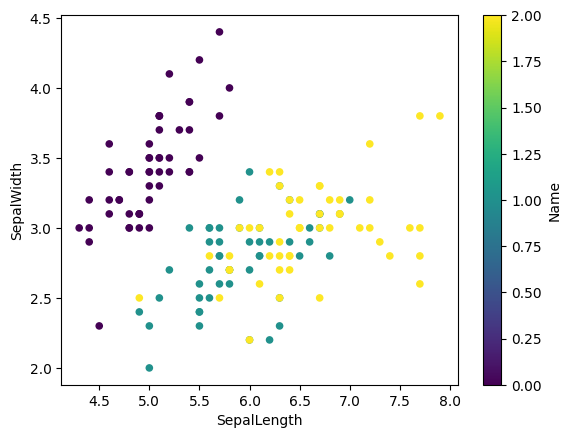

In [54]:
agent.run("SepalLengthとSepalWidthを使い、Nameごとに色分けした散布図を作成してください")

# Toolkit:Python Agent

In [96]:
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool

agent = create_python_agent(
    llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    agent_executor_kwargs={"handle_parsing_errors": True},
)

In [87]:
result = agent.run("data2/iris.dataをheader=0で読み込んで、RandomForestで分類するプログラムを作成してください。")



> Entering new  chain...

Invoking: `Python_REPL` with `import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# データの読み込み
data = pd.read_csv('data2/iris.data', header=0)

# 特徴量とターゲットの分割
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# モデルの作成と学習
model = RandomForestClassifier()
model.fit(X, y)

# 予測
predictions = model.predict(X)

predictions`


```python
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# データの読み込み
data = pd.read_csv('data2/iris.data', header=0)

# 特徴量とターゲットの分割
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# モデルの作成と学習
model = RandomForestClassifier()
model.fit(X, y)

# 予測
predictions = model.predict(X)

predictions
```

このプログラムは、`data2/iris.data`をヘッダー行を0として読み込み、Random Forestで分類するものです。予測結果は`predictions`として出力されます。

> Finished chain.


In [88]:
print(result)

```python
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# データの読み込み
data = pd.read_csv('data2/iris.data', header=0)

# 特徴量とターゲットの分割
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# モデルの作成と学習
model = RandomForestClassifier()
model.fit(X, y)

# 予測
predictions = model.predict(X)

predictions
```

このプログラムは、`data2/iris.data`をヘッダー行を0として読み込み、Random Forestで分類するものです。予測結果は`predictions`として出力されます。
